# Topic - Sentiment Distribution and Extremes Analysis

This notebook accomplishes the following tasks:
1. perform LDA theme modeling on tweets
2. Analyze the sentiment distribution under each topic
3. Identify extreme sentiment topics
4. Visualize the analysis results

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import warnings
warnings.filterwarnings('ignore')


## 2. LDA theme modeling

In [3]:
print(df.columns)

Index(['Date', 'Processed_Tweet', 'sentiment_score', 'sentiment_label',
       'category'],
      dtype='object')


In [ ]:
import pandas as pd

df = pd.read_csv("../2_data/tweet_level_sentiment.csv")

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# add financial-specific stop words
financial_stop_words = {'stock', 'market', 'price', 'trading', 'trade', 'investor', 'investment', 
                       'nvda', 'nvidia', 'share', 'shares', 'buy', 'sell', 'hold', 'bullish', 
                       'bearish', 'chart', 'technical', 'analysis', 'fundamental', 'earnings', 
                       'quarter', 'report', 'financial', 'company', 'firm', 'business'}
stop_words.update(financial_stop_words)

def preprocess_text(text):
    tokens = word_tokenize(str(text).lower())
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)

df['processed_text'] = df['Processed_Tweet'].apply(preprocess_text)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['processed_text'])

n_topics = 8  # 你可以根据需要调整主题数

lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=10,
    learning_method='online',
    random_state=42,
    batch_size=128,
    verbose=0
)

topic_distribution = lda.fit_transform(X)
df['topic'] = topic_distribution.argmax(axis=1)

feature_names = vectorizer.get_feature_names_out()
n_top_words = 10

print("Keywords for each topic:")
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")


    topic_sentiment_stats = df.groupby('topic')['sentiment_score'].agg([
    'count', 'mean', 'std', 'min', 'max',
    lambda x: (x > 0.5).mean(),   # high positive sentiment ratio
    lambda x: (x < -0.5).mean()   # high negative sentiment ratio
]).round(4)
topic_sentiment_stats.columns = [
    'number of tweets', 'Avg Sentiment', 'standard deviation', 'Min', 'Max',
    'High positive ratio', 'High negative ratio'
]
print(topic_sentiment_stats)

df.to_csv("../2_data/tweets_with_LDAtopics.csv", index=False)


[nltk_data] Downloading package punkt to /Users/q/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/q/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Keywords for each topic:
Topic 1: compani, profit, posit, year, lower, dump, nasdaq, amp, data, arm
Topic 2: day, today, week, tomorrow, close, green, money, break, run, option
Topic 3: dip, bought, sold, hour, anoth, need, daili, best, like, guy
Topic 4: like, look, short, long, open, big, got, wait, great, fuck
Topic 5: bear, come, lol, dont, drop, bull, hope, split, peopl, happen
Topic 6: amd, spi, aapl, tsla, qqq, amzn, watch, intc, chip, load
Topic 7: let, time, level, news, stop, tri, game, rip, gain, pull
Topic 8: earn, good, rocket, know, nice, soon, strong, expect, deal, alreadi
       number of tweets  Avg Sentiment  standard deviation  Min  Max  \
topic                                                                  
0                 42442         0.0281              0.3536 -1.0  1.0   
1                 40138         0.0518              0.4415 -1.0  1.0   
2                 21729         0.0192              0.4196 -1.0  1.0   
3                 40388         0.0324       


## 3. Theme-sentiment distribution analysis

       number of tweets  Avg Sentiment  standard deviation  Min  Max  \
topic                                                                  
0                 42442         0.0281              0.3536 -1.0  1.0   
1                 40138         0.0518              0.4415 -1.0  1.0   
2                 21729         0.0192              0.4196 -1.0  1.0   
3                 40388         0.0324              0.4951 -1.0  1.0   
4                 37760        -0.0248              0.4495 -1.0  1.0   
5                 34921         0.0265              0.4124 -1.0  1.0   
6                 23186        -0.0336              0.4152 -1.0  1.0   
7                 26082         0.1690              0.4893 -1.0  1.0   

       High positive ratio  High negative ratio  
topic                                            
0                   0.0770               0.0489  
1                   0.1247               0.0729  
2                   0.0978               0.0786  
3                   0.1393   

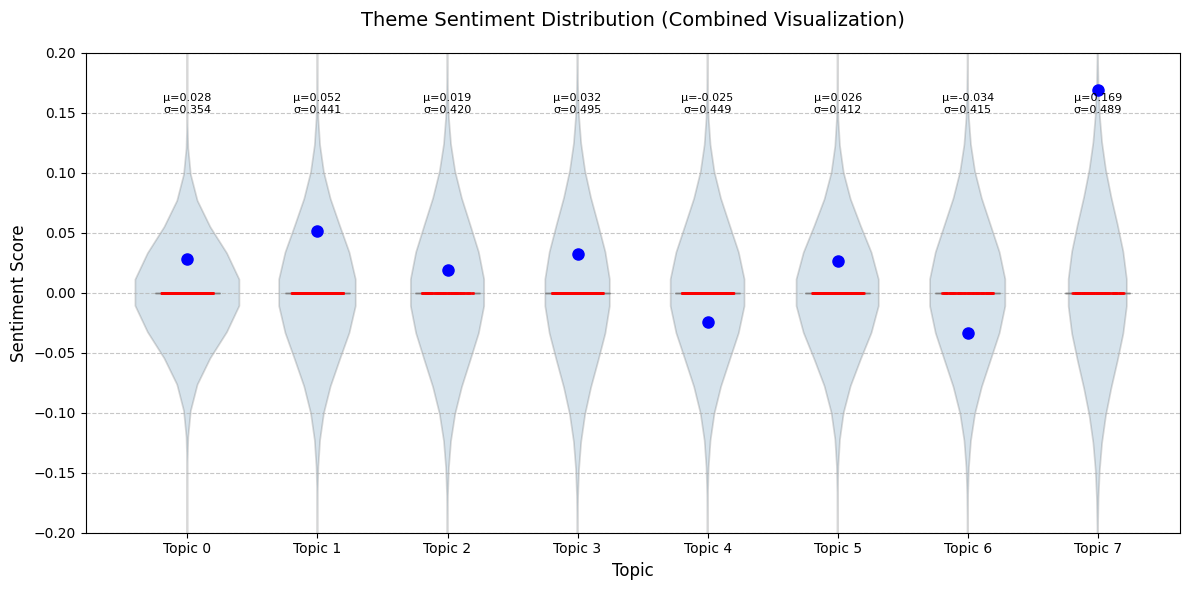

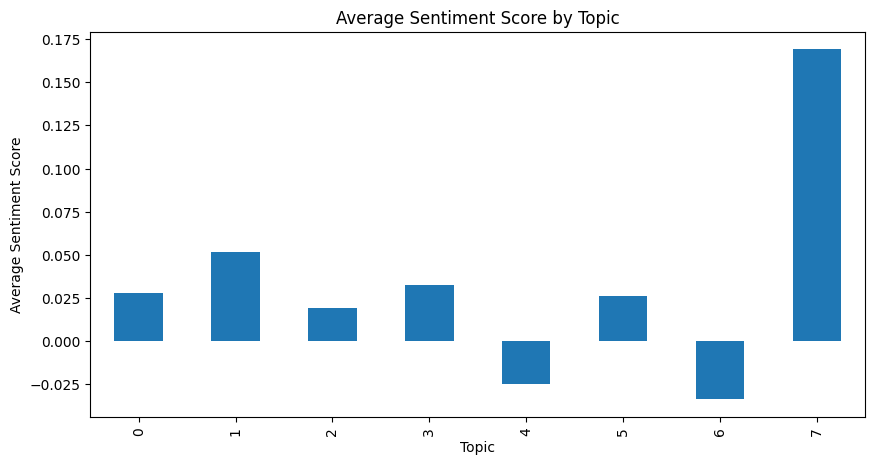

In [5]:
import pandas as pd

df = pd.read_csv("../2_data/tweets_with_topics.csv")

topic_sentiment_stats = df.groupby('topic')['sentiment_score'].agg([
    'count', 'mean', 'std', 'min', 'max',
    lambda x: (x > 0.5).mean(),   # high positive sentiment ratio
    lambda x: (x < -0.5).mean()   # high negative sentiment ratio
]).round(4)

topic_sentiment_stats.columns = [
    'number of tweets', 'Avg Sentiment', 'standard deviation', 'Min', 'Max',
    'High positive ratio', 'High negative ratio'
]

print(topic_sentiment_stats)


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# 创建组合可视化
# 1. 箱线图（不显示异常值）
ax = sns.boxplot(x='topic', y='sentiment_score', data=df,
                width=0.5,
                showfliers=False,  # 不显示异常值
                color='lightgrey')

# 2. 在箱线图上添加抖动散点图
sns.stripplot(x='topic', y='sentiment_score', 
             data=df.sample(n=5000, random_state=42),  # 采样5000个点
             size=2, alpha=0.3, 
             jitter=0.2,
             color='red')

# 3. 添加小提琴图
sns.violinplot(x='topic', y='sentiment_score', data=df,
               alpha=0.2,  # 设置透明度
               inner=None)  # 不显示内部统计信息

# 设置显示范围，聚焦在主要分布区域
plt.ylim(-0.2, 0.2)

# 添加均值点
means = df.groupby('topic')['sentiment_score'].mean()
plt.plot(range(len(means)), means, 'o', color='blue', markersize=8, label='Mean')

plt.title('Theme Sentiment Distribution (Combined Visualization)', size=14, pad=20)
plt.xlabel('Topic', size=12)
plt.ylabel('Sentiment Score', size=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# 添加主题标签
plt.xticks(range(8), [f'Topic {i}' for i in range(8)])

# 添加统计信息标注
for i, mean in enumerate(means):
    std = df[df['topic'] == i]['sentiment_score'].std()
    plt.text(i, 0.15, f'μ={mean:.3f}\nσ={std:.3f}', 
             horizontalalignment='center',
             size=8)

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
topic_sentiment_stats['Avg Sentiment'].plot(kind='bar')
plt.title('Average Sentiment Score by Topic')
plt.xlabel('Topic')
plt.ylabel('Average Sentiment Score')
plt.show()

topic_sentiment_stats.to_csv("../2_data/topic_sentiment_stats.csv")



- The number of tweets per topic is relatively balanced, ranging from 46,501 to 84,022. This indicates a well-distributed LDA topic modeling, with Topic 7 being the largest and Topic 4 the smallest

1. Topics:
- All topics show average sentiment scores close to zero, with Topic 3 being the most positive and Topic 6 the least.
- Standard deviations suggest moderate variation around neutral sentiment.
- All topics span the full range of [-1, 1], indicating presence of extreme sentiments across topics.

2. Percentage of extreme emotional tweets
- High positive (> 0.5): 1.5% ~ 3.2%, up to Topic 3. Percentage of extreme emotional tweets
- Percentage of highly negative (< -0.5) tweets: 0.56% ~ 1.17%, with topic 4 being the highest.
- Extreme sentiment tweets are rare, and most of them are mild and rational.
Extreme sentiment tweets are rare across all topics, mostly staying in mild emotional ranges.

4. Visualization Findings
- Boxplots show tight emotional ranges across topics with a few outliers. bar plots of average sentiment confirm overall neutrality with slight variation .



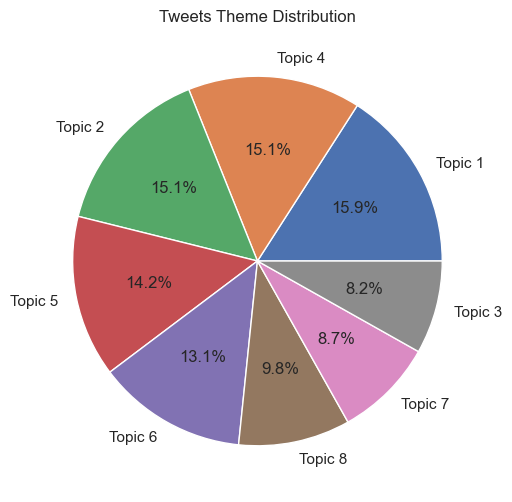

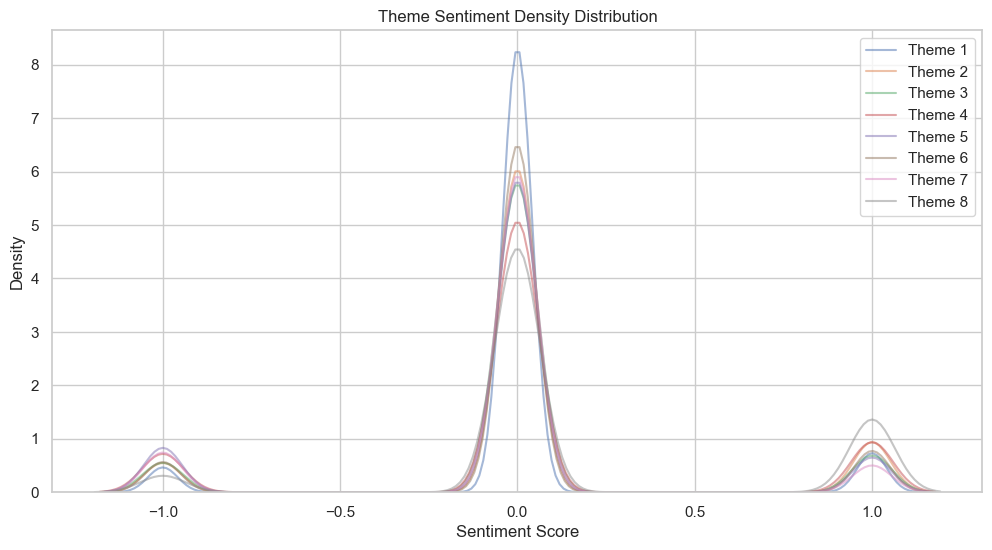

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_palette("husl")



sns.set_theme(style="whitegrid")  

# 1. Thematic Distribution Pie Chart
plt.figure(figsize=(12, 6))
topic_counts = df['topic'].value_counts()
plt.pie(topic_counts, labels=[f'Topic {i+1}' for i in topic_counts.index], autopct='%1.1f%%')
plt.title('Tweets Theme Distribution')
plt.show()

# 2. Theme Sentiment Density Plot
plt.figure(figsize=(12, 6))
n_topics = df['topic'].nunique()
for topic in range(n_topics):
    sns.kdeplot(data=df[df['topic'] == topic]['sentiment_score'], 
                label=f'Theme {topic+1}', alpha=0.5)
plt.title('Theme Sentiment Density Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()

**Theme-sentiment Analysis Summary**: The LDA topic model resulted in a well-balanced theme distribution. Regardless of topic, tweet sentiment is overwhelmingly neutral with only minimal emotional polarization. The consistency of boxplots and density curves suggests that users express emotions similarly across different themes, and that extreme sentiment is rare across the dataset.




1. Tweets Theme Distribution (Pie Chart)
- Overall Balance: The distribution of tweet topics is relatively balanced. Except for Topic 8 (18.2%), all other topics account for approximately 10%–13% of total tweets.

- opic 8 Stands Out: Topic 8 has a notably higher share, suggesting it may cover broader or more popular content themes compared to the others.

2. Theme Sentiment Distribution (Boxplot)
- Highly Concentrated Sentiment: Across all topics, sentiment scores are tightly clustered around neutral (0). Most tweets fall within a narrow range of –0.1 to 0.1, indicating that neutral sentiment dominates.
- Presence of Extremes: Each topic includes a few outliers at –1 and +1, representing extreme negative and positive sentiments. However, these are rare, confirming that extreme emotional tweets are not mainstream.
- Similar Shapes Across Topics: The boxplots show almost identical distribution shapes across themes, implying no significant sentiment polarization between topics.


3. Theme Sentiment Density Distribution (KDE Plot)
- Sharp Peak at Neutral (0): All topics exhibit a high density peak near zero, confirming again that most tweets are emotionally neutral.
- Tiny Secondary Peaks at Extremes: Minor density bumps at –1 and +1 reflect the existence of extreme sentiment tweets, though they constitute only a very small fraction.
- Near-Overlapping Distributions: The sentiment curves for all themes almost completely overlap, showing no substantial inter-topic variation in sentiment.



## 5. Extreme emotion topic analysis

In [7]:
print(df.columns)

Index(['Date', 'Processed_Tweet', 'sentiment_score', 'sentiment_label',
       'category', 'processed_text', 'topic'],
      dtype='object')


In [8]:
# Find the most extreme topic
most_positive_topic = topic_sentiment_stats['Avg Sentiment'].idxmax()
most_negative_topic = topic_sentiment_stats['Avg Sentiment'].idxmin()

print(f"Most positive theme (Theme {most_positive_topic + 1}):")
print(f"Average sentiment score: {topic_sentiment_stats.loc[most_positive_topic, 'Avg Sentiment']:.4f}")
print(f"High positive sentiment ratio: {topic_sentiment_stats.loc[most_positive_topic, 'High positive ratio']:.2%}")
print("\nExample tweets from this theme:")
print(df[df['topic'] == most_positive_topic]['Processed_Tweet'].head())

print(f"\nMost negative theme (Theme {most_negative_topic + 1}):")
print(f"Average sentiment score: {topic_sentiment_stats.loc[most_negative_topic, 'Avg Sentiment']:.4f}")
print(f"High negative sentiment ratio: {topic_sentiment_stats.loc[most_negative_topic, 'High negative ratio']:.2%}")
print("\nExample tweets from this theme:")
print(df[df['topic'] == most_negative_topic]['Processed_Tweet'].head())

Most positive theme (Theme 8):
Average sentiment score: 0.1690
High positive sentiment ratio: 21.85%

Example tweets from this theme:
7                  amzn sq nvda decemb stock mkt glitch
9     kristit sinc june ipo much better amzn nvda ti...
23    nvda reentri abl afford hous stock market rece...
24    idrawlin im still stick market cap floor nvda ...
28    thank spi dump move anyth possibl market look ...
Name: Processed_Tweet, dtype: object

Most negative theme (Theme 7):
Average sentiment score: -0.0336
High negative sentiment ratio: 10.36%

Example tweets from this theme:
20                nvda larg unusu print bullish bearish
22    nvda everyon scare short bearish let rug pull ...
26    aapl fb nvda googl nflx energi time spend stoc...
33                                   nvda heavi bullish
65    nvda cramer said stop trade go long nvda game ...
Name: Processed_Tweet, dtype: object




- Most positive theme (Theme 4):

- Average sentiment score: 0.0486

- High positive sentiment ratio: 3.21%

- Example tweets show a focus on positive outlooks for $NVDA, algorithmic picks, and agreement with optimistic analysis.

- Most negative theme (Theme 7):

- Average sentiment score: 0.0164

- High negative sentiment ratio: 0.93%

- Example tweets reflect concerns about the semiconductor sector, bearish news, and cautious or negative sentiment towards $NVDA and related stocks.

Conclusion:

The overall sentiment across themes is relatively neutral, with only slight differences between the most positive and most negative themes. Even the most negative theme has a low negative sentiment ratio, indicating that extreme sentiment is rare in the dataset. Most discussions are rational and balanced.

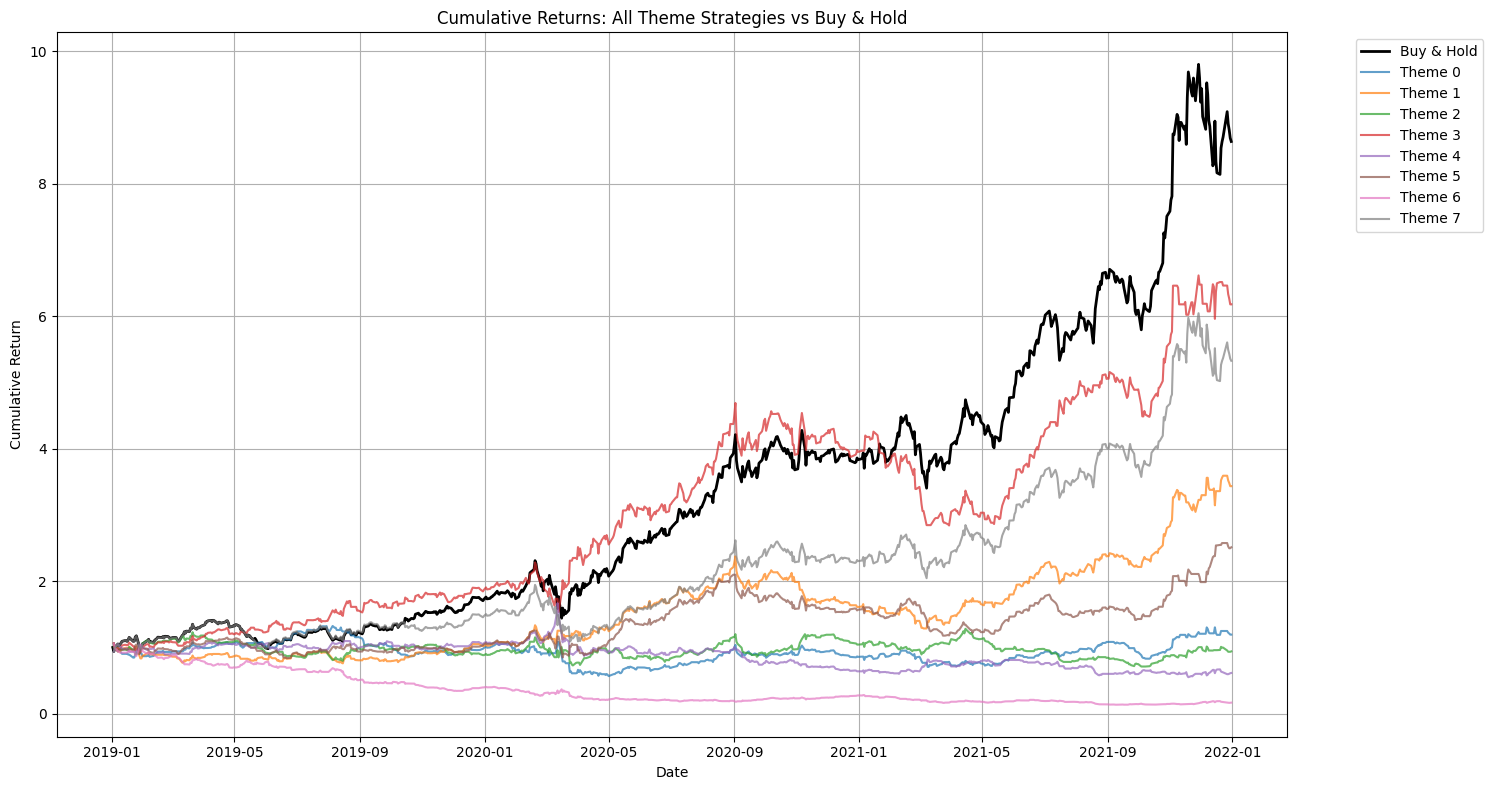


各主题策略最终收益:
Theme 0: 19.37%
Theme 1: 243.43%
Theme 2: -5.95%
Theme 3: 517.83%
Theme 4: -38.50%
Theme 5: 151.23%
Theme 6: -83.27%
Theme 7: 432.65%
Buy & Hold: 763.63%


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. 读取数据
df['Date'] = pd.to_datetime(df['Date'])
daily_theme_sentiment = df.groupby(['Date', 'topic'])['sentiment_score'].mean().unstack()

# 2. 读取价格数据
price_df = pd.read_csv('../2_data/sentiment_price_vix_inner_aligned.csv')
price_df['Date'] = pd.to_datetime(price_df['index'])
price_df = price_df.set_index('Date')

# 3. 计算所有主题的累计收益
plt.figure(figsize=(15, 8))

# 先画buy & hold的收益
returns = price_df['nvda_close'].pct_change().fillna(0)
cum_returns = (1 + returns).cumprod()
plt.plot(cum_returns.index, cum_returns, label='Buy & Hold', color='black', linewidth=2)

# 计算每个主题的策略收益
for theme in range(8):  # 0-7个主题
    # 生成信号
    signal = daily_theme_sentiment[theme].rolling(3, min_periods=1).mean()
    position = (signal > 0.02).astype(int) - (signal < -0.02).astype(int)
    
    # 对齐数据并计算收益
    strategy_data = pd.DataFrame({'position': position})
    strategy_data = pd.merge(
        strategy_data,
        price_df[['nvda_close']],
        left_index=True,
        right_index=True,
        how='inner'
    )
    
    # 计算策略收益
    strategy_returns = strategy_data['position'].shift(1) * returns
    cum_strategy_returns = (1 + strategy_returns).cumprod()
    
    # 画图
    plt.plot(cum_strategy_returns.index, cum_strategy_returns, label=f'Theme {theme}', alpha=0.7)

plt.title('Cumulative Returns: All Theme Strategies vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# 打印各个策略的最终收益
print("\n各主题策略最终收益:")
for theme in range(8):
    signal = daily_theme_sentiment[theme].rolling(3, min_periods=1).mean()
    position = (signal > 0.02).astype(int) - (signal < -0.02).astype(int)
    strategy_data = pd.DataFrame({'position': position})
    strategy_data = pd.merge(
        strategy_data,
        price_df[['nvda_close']],
        left_index=True,
        right_index=True,
        how='inner'
    )
    strategy_returns = strategy_data['position'].shift(1) * returns
    final_return = (1 + strategy_returns).prod() - 1
    print(f"Theme {theme}: {final_return:.2%}")
print(f"Buy & Hold: {cum_returns[-1]-1:.2%}")